#### ESTA ETAPA ESTÁ EM DESENVOLVIMENTO, TODAS AS INFORMAÇÕES AQUI PRESENTES NECESSITAM DE REVISÃO.

### Start (00:37)[08 de abril]

Os manuais teóricos das bibliotecas utilizadas neste trabalho estão localizados nas pasta 'ic_cnpq_2021/tutoriais&questoes/jupyter_notebooks/'.
 
 Este notebook é um guia para a automação dos processos estão localizados na pasta 'ic_cnpq_2021/tutoriais&questoes/test_scripts/'.
 
 Este é o script 1_database_cration, com ele trataremos nossos dados brutos (geológicos e geofísicos) para introduzirmos em nosso banco de dados.
 
 Para tal, será necessária as bibliotecas:
 - #1 - Pandas, Numpy e Matplotlib para importar, tratar e visualizar os nossos dados geofísicos brutos.
 - #2 - Geopandas para importar os dados vetoriais representando nossas informações geológicas.

### --- IMPORTING --- 


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd 
import verde as vd
import pyproj

from shapely import geometry

In [2]:
# # # 3022------------------- Setting Columns to work ------------------------------
columns_m_14area = 'ALTURA BARO DATA FID GPSALT HORA IGRF LAT_WGS LONG_WGS MAGBASE MAGBRU MAGCOM MAGCOR MAGIGRF MAGMIC MAGNIV MDT X X_WGS Y Y_WGS'.split(
    " ")

# mag_3022 ---------------------------------------------------------------------
m_3022 = pd.read_csv('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/xyz/Área 14/XYZ/Area_14_mag.XYZ',
                         names=columns_m_14area,
                         delim_whitespace=True,
                         skiprows=8,
                         usecols=['X', 'Y', 'LAT_WGS', 'LONG_WGS', 'MAGIGRF', 'MDT'],
                         na_values=('*'),   
                         dtype=('float'))
                                            ## Atenção, para importar os dados corretamente se fez necessária
                                            ## a adição destes argumentos nesta etapa de importação.
                                            ## Este procedimento está explicitado nos tutoriais.
m_3022 = m_3022.dropna(inplace=False)       ## Ao que tudo indica, este arquivo XYZ já foi pre-tratado


# Setting projections
# South America WGS 84 Geográfica
p1 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# WGS84 UTM
p2 = pyproj.Proj("+proj=utm +zone=21 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

m_3022['X_WGS'], m_3022['Y_WGS'] = pyproj.transform(p1, p2,
                                                m_3022.LONG_WGS.values,
                                                m_3022.LAT_WGS.values)

# WGS 84 Geográficas
p3 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

m_3022['LATITUDE'], m_3022['LONGITUDE'] = pyproj.transform(p1, p3,
                                                        m_3022.LAT_WGS.values,
                                                        m_3022.LONG_WGS.values)

/home/nazumpa/anaconda3/envs/geocoding/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/home/nazumpa/anaconda3/envs/geocoding/lib/python3.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


In [30]:
# Getting Region
varginha_region = ((gpd.read_file('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/mapas_100k.gpkg',
                                 layer='varginha').unary_union).bounds)

region = (varginha_region[0],varginha_region[2],
          varginha_region[1],varginha_region[3])

# Cutting Data by Region
m_varginha = m_3022[vd.inside((m_3022.LONGITUDE, m_3022.LATITUDE), region=region)]

m_varginha.to_csv('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/xyz/m_varginha.xyz', index=False)


### Interpolating

(array([3., 1., 0., 2., 4.]),
 array([0.88748172, 0.89195855, 0.89643538, 0.90091221, 0.90538904,
        0.90986587]),
 <BarContainer object of 5 artists>)

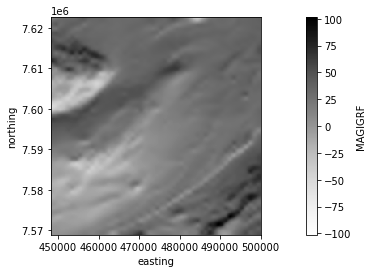

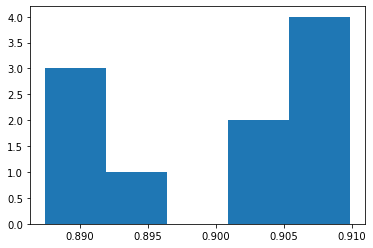

In [12]:
data = m_varginha
coords = (data.X , data.Y)

chain = vd.Chain([
    ('trend',vd.Trend(degree=1)),
    ('reduce',vd.BlockReduce(np.mean, spacing=1000)),
    ('spline',vd.Spline()),
])

chain.fit(coords,data.MAGIGRF)

# Predicting to a sythetic grid with the fitted function.
grid = chain.grid(spacing=200, data_names=['MAGIGRF'])
grid = vd.distance_mask(coords,maxdist=1000,grid=grid)

plt.figure()
grid.MAGIGRF.plot(cmap="Greys")
plt.axis("scaled")


#Model Validation
cv = vd.BlockKFold(spacing=200, n_splits=10, shuffle=True)
scores = vd.cross_val_score(chain, coords, data.MAGIGRF, cv=cv)
scores

plt.figure()
plt.hist(scores, bins='auto')

(array([3., 4., 2., 0., 1.]),
 array([0.89162369, 0.89629041, 0.90095712, 0.90562384, 0.91029056,
        0.91495727]),
 <BarContainer object of 5 artists>)

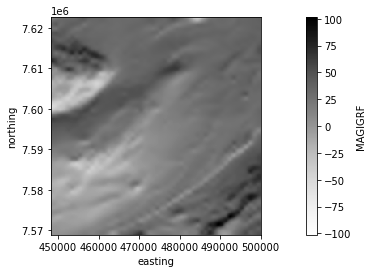

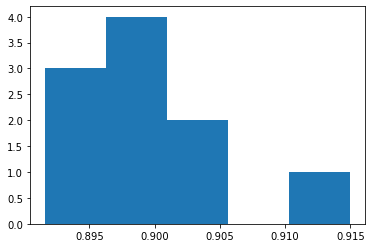

In [11]:
data = m_varginha
coords = (data.X , data.Y)

chain = vd.Chain([
    ('trend',vd.Trend(degree=1)),
    ('reduce',vd.BlockReduce(np.mean, spacing=1000)),
    ('spline',vd.Spline()),
])

chain.fit(coords,data.MAGIGRF)

# Predicting to a sythetic grid with the fitted function.
grid = chain.grid(spacing=200, data_names=['MAGIGRF'])
grid = vd.distance_mask(coords,maxdist=1000,grid=grid)

plt.figure()
grid.MAGIGRF.plot(cmap="Greys")
plt.axis("scaled")


#Model Validation
cv = vd.BlockKFold(spacing=200, n_splits=10, shuffle=True)
scores = vd.cross_val_score(chain, coords, data.MAGIGRF, cv=cv)
scores

plt.figure()
plt.hist(scores, bins='auto')

In [2]:
# 3022
# # -------------------- Setting Columns to work ------------------------------
columns_m_14area = 'ALTURA BARO DATA FID GPSALT HORA IGRF LAT_WGS LONG_WGS MAGBASE MAGBRU MAGCOM MAGCOR MAGIGRF MAGMIC MAGNIV MDT X X_WGS Y Y_WGS'.split(
    " ")

# mag_3022 ---------------------------------------------------------------------
m_3022 = pd.read_csv('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/xyz/Área 14/XYZ/Area_14_mag.XYZ',
                         names=columns_m_14area,
                         delim_whitespace=True,
                         skiprows=8,
                         usecols=['X', 'Y', 'LAT_WGS', 'LONG_WGS', 'MAGIGRF', 'MDT'],
                         na_values=('*'),   
                         dtype=('float'))
                                            ## Atenção, para importar os dados corretamente se fez necessária
                                            ## a adição destes argumentos nesta etapa de importação.
                                            ## Este procedimento está explicitado nos tutoriais.
m_3022 = m_3022.dropna(inplace=False)       ## Ao que tudo indica, este arquivo XYZ já foi pre-tratado

m_3022

,LAT_WGS,LONG_WGS,MAGIGRF,MDT,X,Y
0,-21.236695,-47.054024,114.455,699.38,286856.47,7650282.78
1,-21.236764,-47.054026,114.657,698.16,286856.37,7650275.15
2,-21.236833,-47.054028,114.859,697.60,286856.27,7650267.53
3,-21.236901,-47.054030,115.041,696.56,286856.17,7650259.90
4,-21.236970,-47.054032,115.213,695.89,286856.08,7650252.27
...,...,...,...,...,...,...
6760977,-21.069265,-43.998712,17.757,1106.07,604042.42,7669870.71
6760978,-21.069263,-43.998644,17.668,1108.44,604049.47,7669870.89
6760979,-21.069261,-43.998576,17.589,1112.29,604056.51,7669871.08
6760980,-21.069258,-43.998509,17.501,1115.51,604063.56,7669871.26


In [3]:
# Setting projections
# South America WGS 84 Geográfica
p1 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# WGS84 UTM
p2 = pyproj.Proj("+proj=utm +zone=21 +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

m_3022['X_WGS'], m_3022['Y_WGS'] = pyproj.transform(p1, p2,
                                                m_3022.LONG_WGS.values,
                                                m_3022.LAT_WGS.values)

# WGS 84 Geográficas
p3 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

m_3022['LATITUDE'], m_3022['LONGITUDE'] = pyproj.transform(p1, p3,
                                                        m_3022.LAT_WGS.values,
                                                        m_3022.LONG_WGS.values)

'*Esta função apresenta irregularidades (Deprecation Warning)*'

m_3022

/home/nazumpa/anaconda3/envs/geocoding/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # Remove the CWD from sys.path while we load stuff.
/home/nazumpa/anaconda3/envs/geocoding/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


,LAT_WGS,LONG_WGS,MAGIGRF,MDT,X,Y,X_WGS,Y_WGS,LATITUDE,LONGITUDE
0,-21.236695,-47.054024,114.455,699.38,286856.47,7650282.78,1.535898e+06,7.618860e+06,-21.236695,-47.054024
1,-21.236764,-47.054026,114.657,698.16,286856.37,7650275.15,1.535898e+06,7.618852e+06,-21.236764,-47.054026
2,-21.236833,-47.054028,114.859,697.60,286856.27,7650267.53,1.535897e+06,7.618844e+06,-21.236833,-47.054028
3,-21.236901,-47.054030,115.041,696.56,286856.17,7650259.90,1.535896e+06,7.618837e+06,-21.236901,-47.054030
4,-21.236970,-47.054032,115.213,695.89,286856.08,7650252.27,1.535895e+06,7.618829e+06,-21.236970,-47.054032
...,...,...,...,...,...,...,...,...,...,...
6760977,-21.069265,-43.998712,17.757,1106.07,604042.42,7669870.71,1.859292e+06,7.614073e+06,-21.069265,-43.998712
6760978,-21.069263,-43.998644,17.668,1108.44,604049.47,7669870.89,1.859299e+06,7.614073e+06,-21.069263,-43.998644
6760979,-21.069261,-43.998576,17.589,1112.29,604056.51,7669871.08,1.859306e+06,7.614073e+06,-21.069261,-43.998576
6760980,-21.069258,-43.998509,17.501,1115.51,604063.56,7669871.26,1.859313e+06,7.614072e+06,-21.069258,-43.998509


In [4]:
varginha_region = ((gpd.read_file('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/mapas_100k.gpkg',
                                 layer='varginha').unary_union).bounds)
varginha_region

/home/nazumpa/anaconda3/envs/geocoding/lib/python3.7/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


(-45.500000000249976,
 -21.999999999999982,
 -44.999999999999964,
 -21.499999999999993)

In [5]:
region = (varginha_region[0],varginha_region[2],
          varginha_region[1],varginha_region[3])

In [6]:
m_varginha = m_3022[vd.inside((m_3022.LONGITUDE, m_3022.LATITUDE), region=region)]
m_varginha

,LAT_WGS,LONG_WGS,MAGIGRF,MDT,X,Y,X_WGS,Y_WGS,LATITUDE,LONGITUDE
3085949,-21.500006,-45.498803,20.010,841.19,448358.22,7622442.13,1.697198e+06,7.578061e+06,-21.500006,-45.498803
3085950,-21.500064,-45.498803,19.859,840.60,448358.24,7622435.79,1.697198e+06,7.578055e+06,-21.500064,-45.498803
3085951,-21.500121,-45.498803,19.718,841.29,448358.26,7622429.45,1.697197e+06,7.578048e+06,-21.500121,-45.498803
3085952,-21.500178,-45.498803,19.577,841.27,448358.28,7622423.11,1.697197e+06,7.578042e+06,-21.500178,-45.498803
3085953,-21.500236,-45.498803,19.426,841.65,448358.32,7622416.77,1.697196e+06,7.578035e+06,-21.500236,-45.498803
...,...,...,...,...,...,...,...,...,...,...
6626380,-21.523263,-45.499648,25.337,866.46,448278.92,7619867.76,1.696915e+06,7.575455e+06,-21.523263,-45.499648
6626381,-21.523264,-45.499729,25.394,865.04,448270.48,7619867.57,1.696906e+06,7.575456e+06,-21.523264,-45.499729
6626382,-21.523266,-45.499811,25.451,864.96,448262.04,7619867.39,1.696897e+06,7.575456e+06,-21.523266,-45.499811
6626383,-21.523267,-45.499892,25.508,865.01,448253.60,7619867.21,1.696889e+06,7.575457e+06,-21.523267,-45.499892


In [7]:
# m_varginha['geometry'] = [geometry.Point(x, y) for x, y in zip(m_varginha['X'], m_varginha['Y'])]
# m_varginha = m_varginha.set_geometry('geometry')
# print(m_varginha.crs)

In [8]:
m_varginha.to_csv('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/xyz/m_varginha.xyz', index=False)

### Interpolação pelo método de Splines 

In [ ]:
def chain_config(degree,spacing):
        chain = vd.Chain([
            ('trend',vd.Trend(degree)),
            ('reduce',vd.BlockReduce(np.mean, spacing)),
            ('spline',vd.Spline()),
        ])
        return chain
    
def chain_fit():
    chain = chain.fit(coords,data.MAGIGRF)

def predict(spacing,['data_names']):
    grid = vd.distance_mask(coords,maxdist=2000,chain.grid(spacing,data_names))

    

<IPython.core.display.Javascript object>


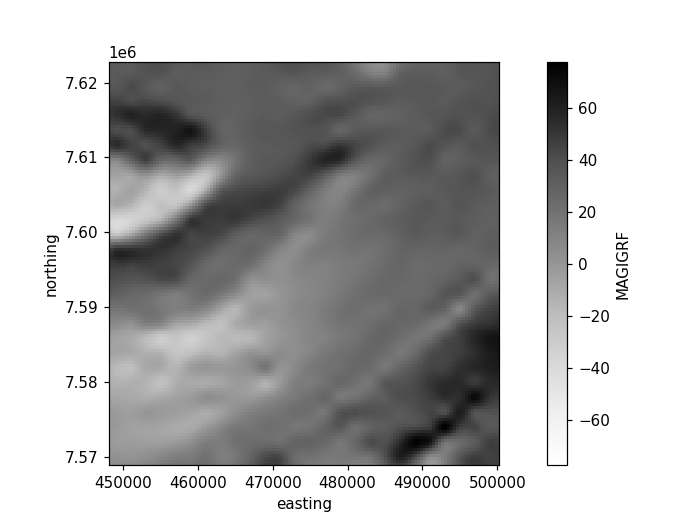

<IPython.core.display.Javascript object>


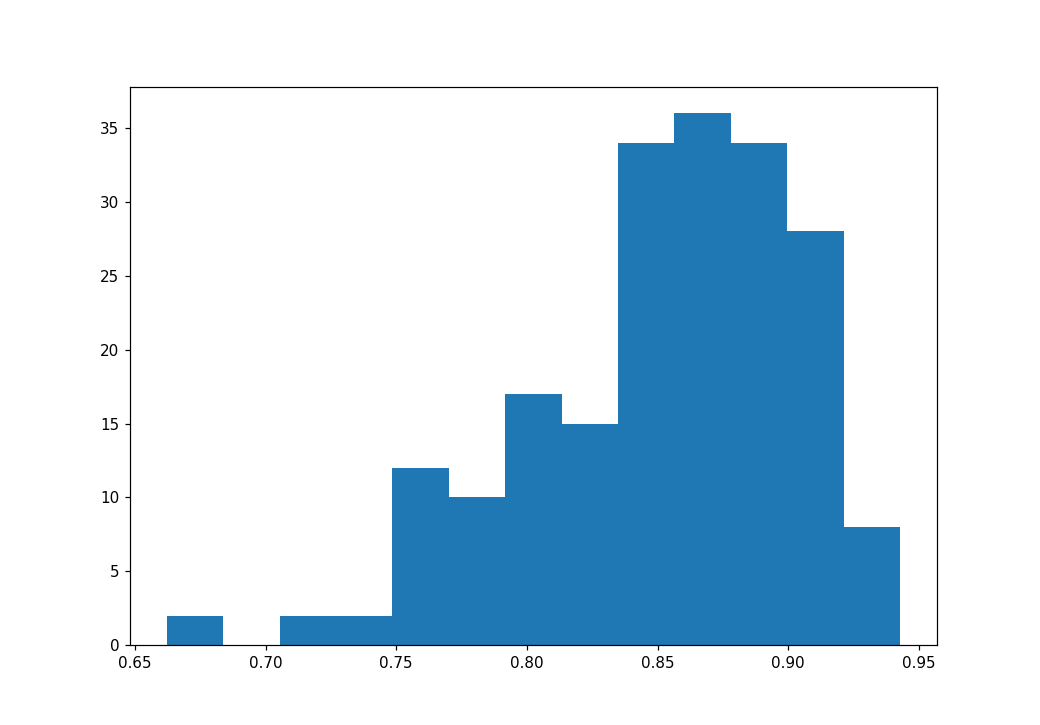

(array([ 2.,  0.,  2.,  2., 12., 10., 17., 15., 34., 36., 34., 28.,  8.]),
 array([0.66218737, 0.68377168, 0.705356  , 0.72694031, 0.74852463,
        0.77010894, 0.79169326, 0.81327757, 0.83486189, 0.8564462 ,
        0.87803052, 0.89961483, 0.92119914, 0.94278346]),
 <BarContainer object of 13 artists>)

In [21]:
data = pd.read_csv('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/xyz/m_varginha.xyz')
coords = (data.X , data.Y)

chain = vd.Chain([
    ('trend',vd.Trend(degree=1)),
    ('reduce',vd.BlockReduce(np.mean, spacing=2000)),
    ('spline',vd.Spline()),
])

chain.fit(coords,data.MAGIGRF)

# Predicting to a sythetic grid with the fitted function.
grid = chain.grid(spacing=400, data_names=['MAGIGRF'])
grid = vd.distance_mask(coords,maxdist=2000,grid=grid)

plt.figure()
grid.MAGIGRF.plot(cmap="Greys")
plt.axis("scaled")


#Model Validation
cv = vd.BlockKFold(spacing=400, n_splits=200, shuffle=True)
scores = vd.cross_val_score(chain, coords, data.MAGIGRF, cv=cv)
scores

plt.figure()
plt.hist(scores, bins='auto')

# Export to NETCDF
# grid.to_netcdf('/home/nazumpa/projetos/ic_cnpq_2021/outputs/vd_splines/MAGIGRF_varginha.netcdf')

<IPython.core.display.Javascript object>


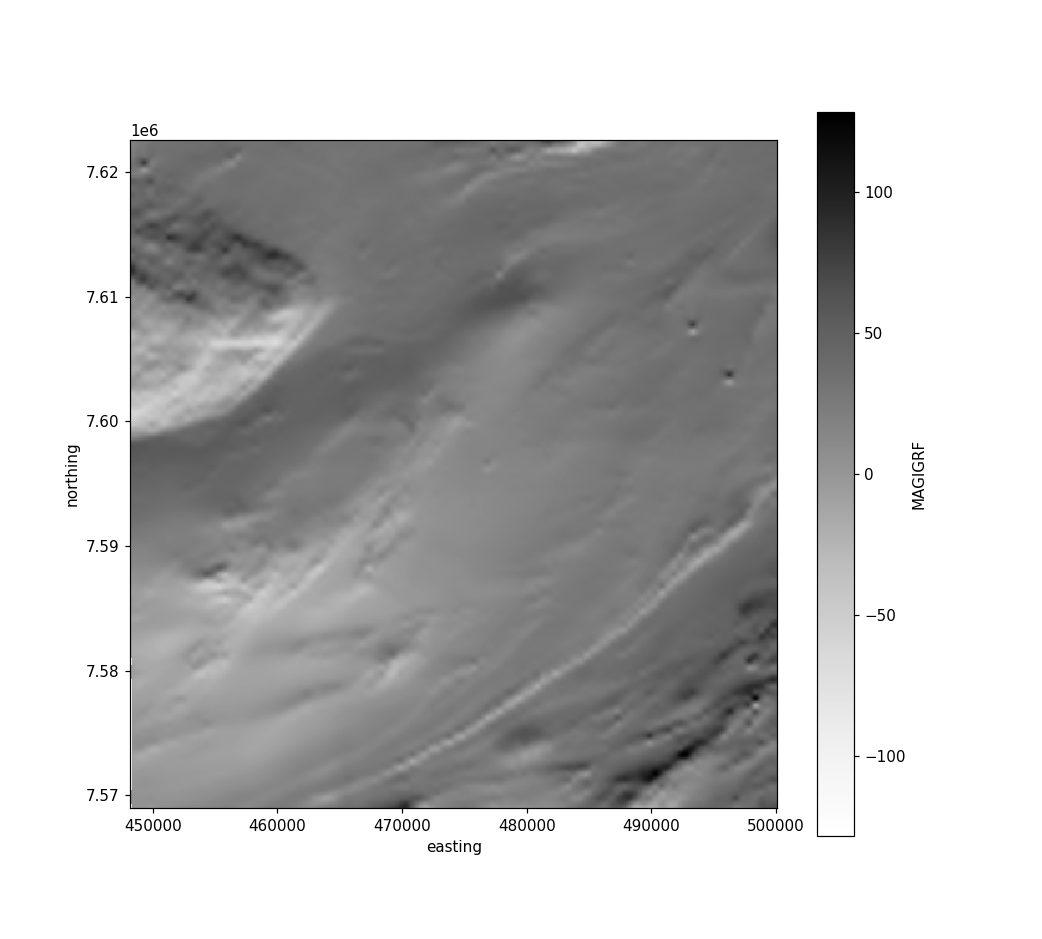

<IPython.core.display.Javascript object>


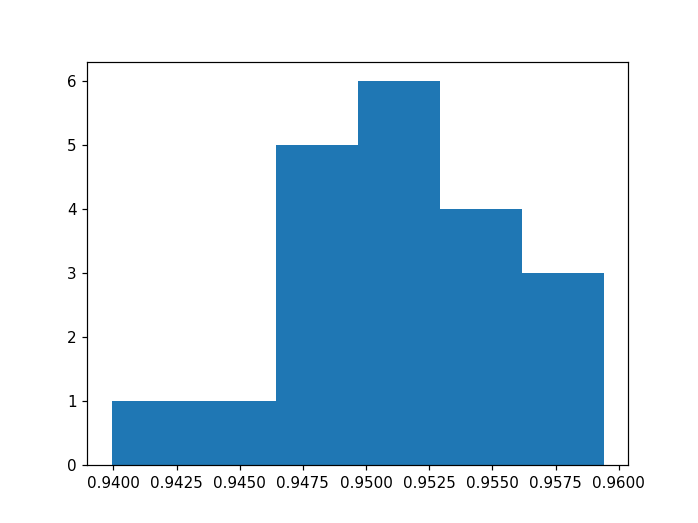

(array([1., 1., 5., 6., 4., 3.]),
 array([0.93993994, 0.94318381, 0.94642767, 0.94967154, 0.9529154 ,
        0.95615927, 0.95940313]),
 <BarContainer object of 6 artists>)

In [28]:
data = pd.read_csv('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/xyz/m_varginha.xyz')
coords = (data.X , data.Y)

chain = vd.Chain([
    ('trend',vd.Trend(degree=1)),
    ('reduce',vd.BlockReduce(np.mean, spacing=500)),
    ('spline',vd.Spline()),
])


chain.fit(coords,data.MAGIGRF)

# Predicting to a sythetic grid with the fitted function.
grid = chain.grid(spacing=100, data_names=['MAGIGRF'])
grid = vd.distance_mask(coords,maxdist=500,grid=grid)

plt.figure()
grid.MAGIGRF.plot(cmap="Greys")
plt.axis("scaled")


#Model Validation
cv = vd.BlockKFold(spacing=100, n_splits=20, shuffle=True)
scores = vd.cross_val_score(chain, coords, data.MAGIGRF, cv=cv)
scores

plt.figure()
plt.hist(scores, bins='auto')

<IPython.core.display.Javascript object>


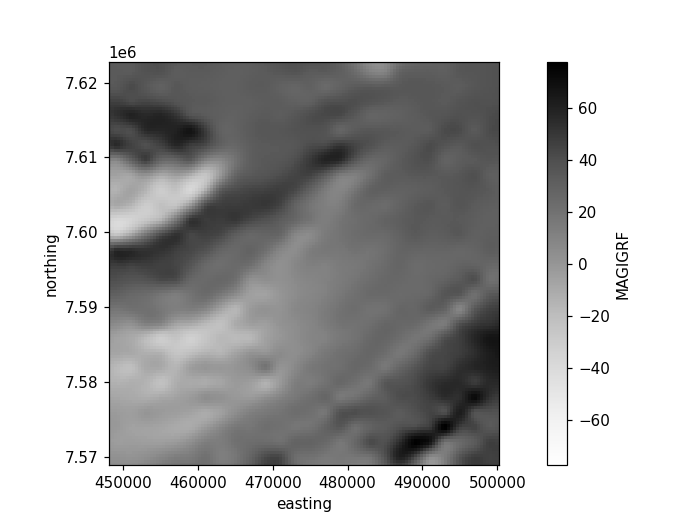

<IPython.core.display.Javascript object>


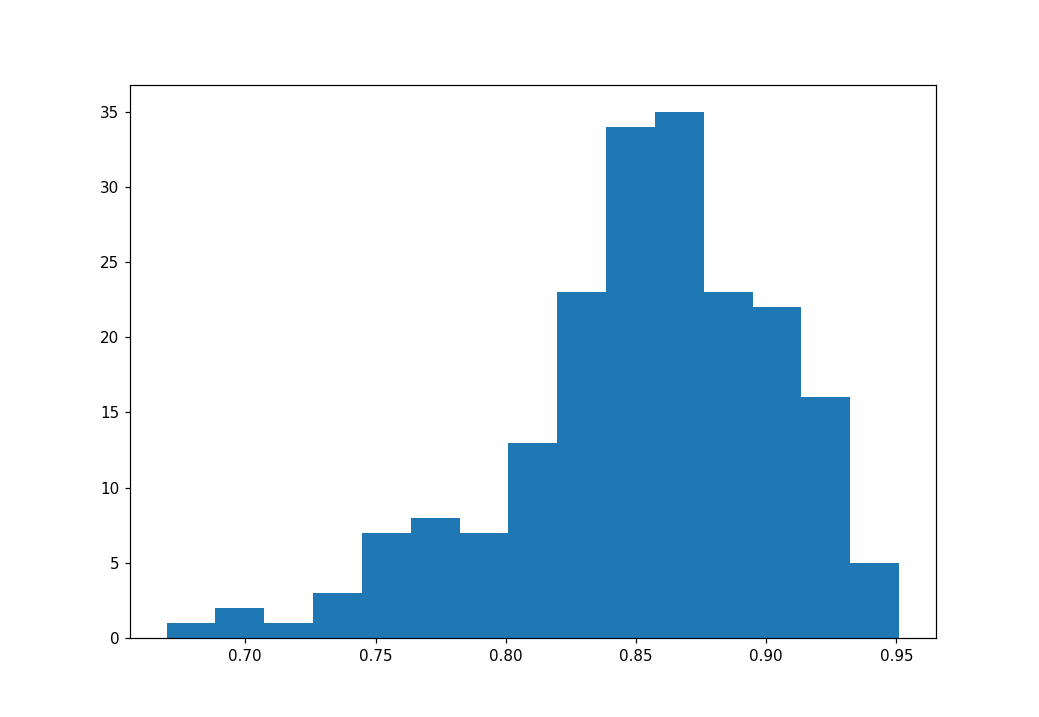

(array([ 1.,  2.,  1.,  3.,  7.,  8.,  7., 13., 23., 34., 35., 23., 22.,
        16.,  5.]),
 array([0.669784  , 0.68853115, 0.70727829, 0.72602544, 0.74477259,
        0.76351974, 0.78226689, 0.80101404, 0.81976118, 0.83850833,
        0.85725548, 0.87600263, 0.89474978, 0.91349693, 0.93224408,
        0.95099122]),
 <BarContainer object of 15 artists>)

In [22]:
data = pd.read_csv('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/xyz/m_varginha.xyz')
coords = (data.X , data.Y)

chain = vd.Chain([
    ('trend',vd.Trend(degree=2)),
    ('reduce',vd.BlockReduce(np.mean, spacing=2000)),
    ('spline',vd.Spline()),
])

chain.fit(coords,data.MAGIGRF)

# Predicting to a sythetic grid with the fitted function.
grid = chain.grid(spacing=400, data_names=['MAGIGRF'])
grid = vd.distance_mask(coords,maxdist=2000,grid=grid)

plt.figure()
grid.MAGIGRF.plot(cmap="Greys")
plt.axis("scaled")


#Model Validation
cv = vd.BlockKFold(spacing=400, n_splits=200, shuffle=True)
scores = vd.cross_val_score(chain, coords, data.MAGIGRF, cv=cv)
scores

plt.figure()
plt.hist(scores, bins='auto')

<IPython.core.display.Javascript object>


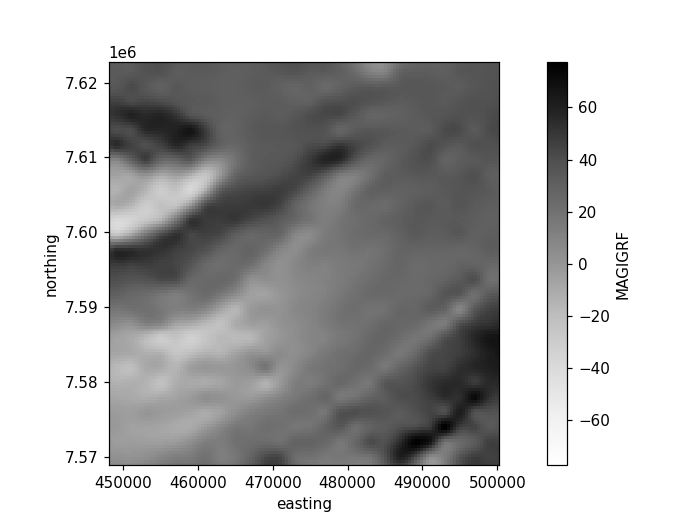

<IPython.core.display.Javascript object>


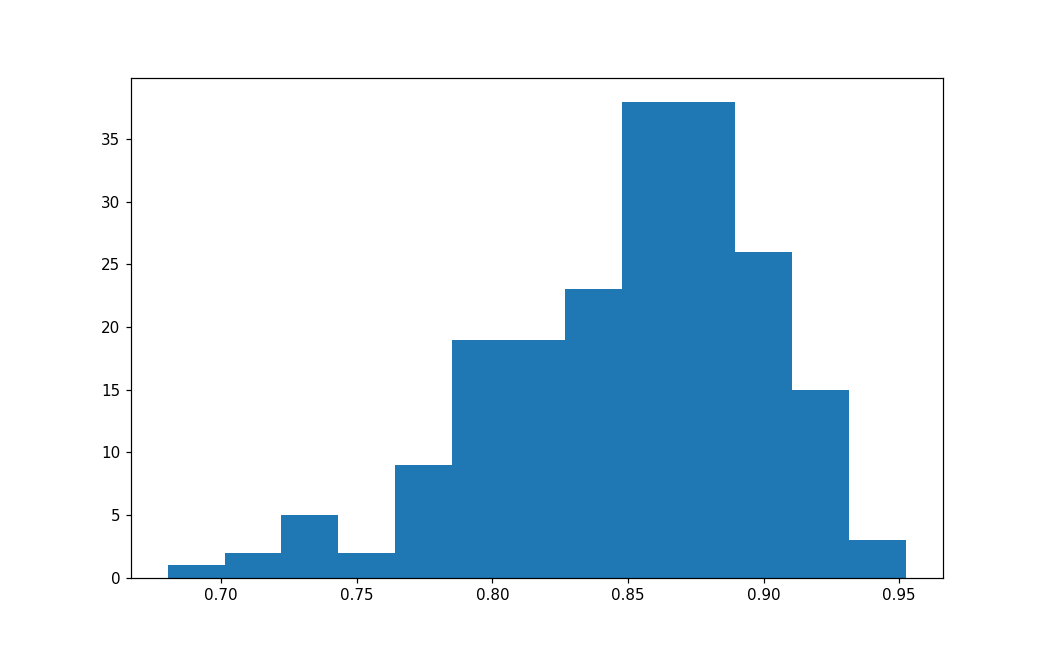

(array([ 1.,  2.,  5.,  2.,  9., 19., 19., 23., 38., 38., 26., 15.,  3.]),
 array([0.68033243, 0.70125686, 0.7221813 , 0.74310573, 0.76403016,
        0.78495459, 0.80587902, 0.82680345, 0.84772788, 0.86865231,
        0.88957675, 0.91050118, 0.93142561, 0.95235004]),
 <BarContainer object of 13 artists>)

In [23]:
data = pd.read_csv('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/xyz/m_varginha.xyz')
coords = (data.X , data.Y)

chain = vd.Chain([
    ('trend',vd.Trend(degree=3)),
    ('reduce',vd.BlockReduce(np.mean, spacing=2000)),
    ('spline',vd.Spline()),
])

chain.fit(coords,data.MAGIGRF)

# Predicting to a sythetic grid with the fitted function.
grid = chain.grid(spacing=400, data_names=['MAGIGRF'])
grid = vd.distance_mask(coords,maxdist=2000,grid=grid)

plt.figure()
grid.MAGIGRF.plot(cmap="Greys")
plt.axis("scaled")


#Model Validation
cv = vd.BlockKFold(spacing=400, n_splits=200, shuffle=True)
scores = vd.cross_val_score(chain, coords, data.MAGIGRF, cv=cv)
scores

plt.figure()
plt.hist(scores, bins='auto')

<IPython.core.display.Javascript object>


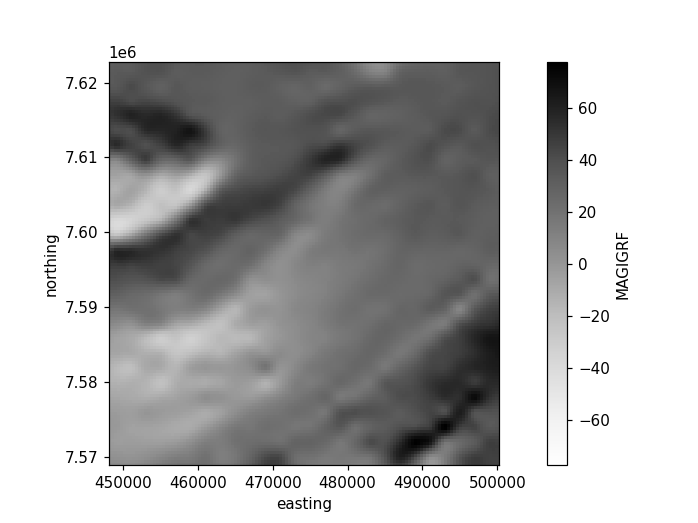

<IPython.core.display.Javascript object>


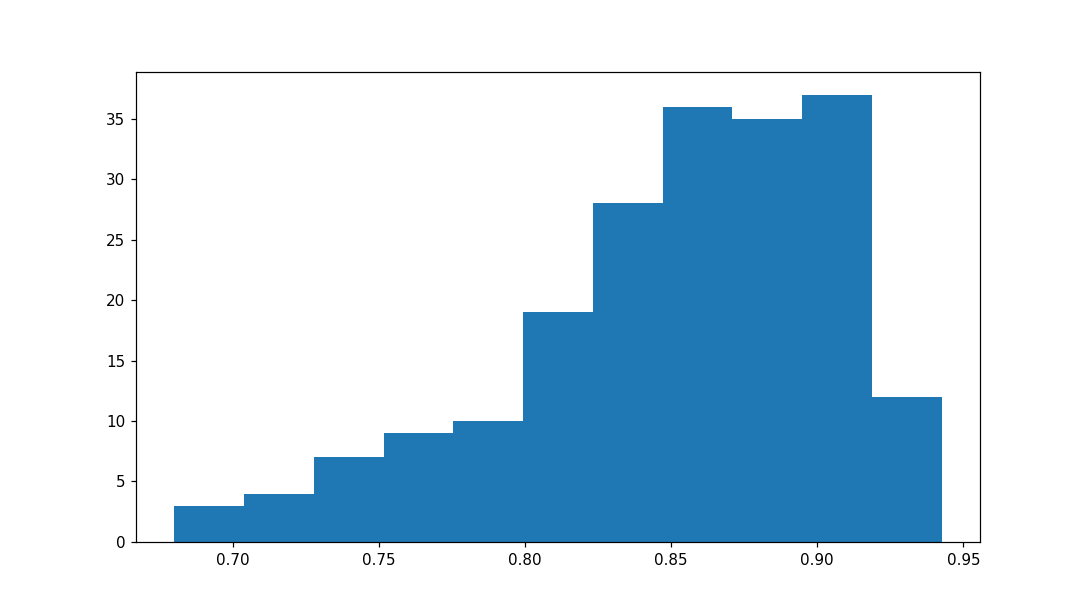

(array([ 3.,  4.,  7.,  9., 10., 19., 28., 36., 35., 37., 12.]),
 array([0.68011545, 0.70396661, 0.72781777, 0.75166893, 0.77552009,
        0.79937125, 0.82322241, 0.84707357, 0.87092473, 0.89477589,
        0.91862705, 0.94247821]),
 <BarContainer object of 11 artists>)

In [25]:
data = pd.read_csv('/home/nazumpa/projetos/ic_cnpq_2021/geo_database/xyz/m_varginha.xyz')
coords = (data.X , data.Y)

chain = vd.Chain([
    ('trend',vd.Trend(degree=4)),
    ('reduce',vd.BlockReduce(np.mean, spacing=2000)),
    ('spline',vd.Spline()),
])

chain.fit(coords,data.MAGIGRF)

# Predicting to a sythetic grid with the fitted function.
grid = chain.grid(spacing=400, data_names=['MAGIGRF'])
grid = vd.distance_mask(coords,maxdist=2000,grid=grid)

plt.figure()
grid.MAGIGRF.plot(cmap="Greys")
plt.axis("scaled")


#Model Validation
cv = vd.BlockKFold(spacing=400, n_splits=200, shuffle=True)
scores = vd.cross_val_score(chain, coords, data.MAGIGRF, cv=cv)
scores

plt.figure()
plt.hist(scores, bins='auto')